## TABLE OF CONTENTS:
* [LIBRARIES](#1)
* [DATA](#2)
* [LOADING DATA](#3)
* [DATA PREPARATION - SELECTED SETS](#4)
* [PREPARING DATA SET](#5)
* [ALGORITHMS](#6)
* [Graph of the dependence of time on the selected algorithm](#7)
* [Graphs of time dependence on the number of rows, column and values in the data set](#8)
* [Cluster distribution and outliers](#9)
* [STIRR- Weight distribution](#10)
* [Method of marking clusters, weights, outliers in the set](#11)
* [Differences in the classification of outliers](#12)
* [Common outliers generated by the STIRR, ROCK and K-modes algorithms](#13)

## LIBRARIES <a class="anchor" id="1"> </a>

Analytical libraries of the Python language were used in the work: SciPy, Scikit-learn, NumPy, Pandas and Matplotlib for data visualization

In [11]:
import sys
import os
try:
    sys.path.append("/usr/local/lib/python3.9/site-packages")
except:
    pass

from preprocessing import fill_empty, drop_empty, variable_coding, variable_encoding
from algorithms import stirr, rock, kmodes
import numpy as np
from scipy import stats
import pandas as pd
from matplotlib import cm
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from collections import Counter
from time import time
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
%matplotlib inline

## DATA <a class="anchor" id="2"></a>
The described data sets were used:

### Primary Tumor Data Set
The Primary Tumor Dataset is one of three databases provided by the Institute of Oncology, which has appeared many times in the literature on machine learning. The collection was obtained from the University Medical Center of the Institute of Oncology in Ljubljana, Yugoslavia and published by M. Zwitter and M. Soklic. The collection concerns primary tumors in humans. Locations primary tumors are places in the body where the tumor appeared for the first time, and from there began to form new tumors in other parts of the body. Data objects are characterized by patient variables such as age, gender, skin type, and sites of metastasis. The purpose of the data set analysis is to determine the starting point at which the tumor appeared. The set contains 338 records, 18 columns and 49 unique values.

### Lymphography Data Set
The dataset is part of primary cancer research in humans. Like the Primary Tumor DataSet, the Lymphography dataset was obtained from the University Medical Center of the Institute of Oncology in Ljubljana, Yugoslavia and published by M. Zwitter and M. Soklic. The set contains 148 records, 19 columns and 62 unique values.


### Congressional Voting Records Data Set
The voting dataset in the US Congress was designated by Jeff Schlimmer. This is the result of the 1984 United States Congress vote. Each record corresponds to one congressman’s vote on 16 issues (e.g., education expenditure, crime). All attributes are logical values. The dataset contains records for 168 Republicans and 267 Democrats. The set contains 434 records, 17 columns and 34 unique values.

### Car Evaluation Data Set
The car rating database was derived from a simple hierarchical decision model originally developed for the DEX demonstration by M. Bohanec, V. Rajkovic. The car rating database directly ties a car to the six input attributes: purchase, maintenance, doors, people, trunk, security. Due to the known concept structure, this database can be particularly useful for testing constructive induction methods and structure discovery. The set contains 1728 records, 7 columns and 26 unique values.

## LOADING DATA <a class="anchor" id="3"></a>

In [12]:
path = "datasets"
df_0 = pd.read_csv(os.path.join(path, "primary-tumor.data.csv"), sep=";")
df_1 = pd.read_csv(os.path.join(path, "lymphography.data.csv"), sep=";")
df_2 = pd.read_csv(os.path.join(path,"house-votes-84.data.csv"), sep=";")
df_3 = pd.read_csv(os.path.join(path, "car.data.csv"), sep=";")

df_2.head()

,republican,n,y,n.1,y.1,y.2,y.3,n.2,n.3,n.4,y.4,?,y.5,y.6,y.7,n.5,y.8
0,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
1,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
2,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
3,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y
4,democrat,n,y,y,n,y,y,n,n,n,n,n,n,y,y,y,y


## DATA PREPARATION - SELECTED SETS <a class="anchor" id="4"></a>

### Dataset after completing the missing values

In [13]:
fill_empty(df_2, list(df_2.columns)).head()

,republican,n,y,n.1,y.1,y.2,y.3,n.2,n.3,n.4,y.4,?,y.5,y.6,y.7,n.5,y.8
0,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,y
1,democrat,n,y,y,n,y,y,n,n,n,n,y,n,y,y,n,n
2,democrat,n,y,y,n,y,y,n,n,n,n,y,n,y,n,n,y
3,democrat,y,y,y,n,y,y,n,n,n,n,y,n,y,y,y,y
4,democrat,n,y,y,n,y,y,n,n,n,n,n,n,y,y,y,y


### Dataset after encoding text values

In [14]:
republicans_after_coding, coding_dictionary = variable_coding(df_2, list(df_2.columns))
republicans_after_coding.head()

,republican,n,y,n.1,y.1,y.2,y.3,n.2,n.3,n.4,y.4,?,y.5,y.6,y.7,n.5,y.8
0,2,3,6,10,13,15,18,22,25,28,31,33,37,39,42,45,49
1,1,5,6,9,14,15,18,22,25,28,31,34,36,39,42,45,50
2,1,3,6,9,12,17,18,22,25,28,31,34,36,39,43,45,48
3,1,4,6,9,12,15,18,22,25,28,31,34,38,39,42,46,48
4,1,3,6,9,12,15,18,22,25,28,31,33,36,39,42,46,48


## PREPARING DATA SET <a class="anchor" id="5"></a>

In [15]:
df_2 = pd.read_csv(os.path.join(path,"house-votes-84.data.csv"), sep=";")
datasets_names = ["primary-tumor", "lymphography", "house-votes", "car"]
rows = []
columns = []
values = []
coding_dict = [None]*4
datasets = [df_0, df_1, df_2, df_3]
for i in range(len(datasets)):
    cat_columns = list(datasets[i].columns)
    datasets[i] = fill_empty(datasets[i], cat_columns)
    datasets[i], coding_dict[i] = variable_coding(datasets[i], cat_columns)
    rows.append(datasets[i].shape[0])
    columns.append(datasets[i].shape[1])
    values.append(np.sum([len(datasets[i][col].unique()) for col in datasets[i]]))
    
df_stats = pd.DataFrame({"Name": datasets_names, "Rows": rows, "Columns": columns, 
              "Values": values})

df_stats

,Name,Rows,Columns,Values
0,primary-tumor,339,18,58
1,lymphography,148,19,62
2,house-votes,434,17,34
3,car,1728,7,26


## ALGORITHMS <a class="anchor" id="6"></a>
By default, the algorithms find about 10% of outliers. The value can be changed by commenting or uncommenting the algorithm parameters, as appropriate.

In [16]:
# 1% of outliers
# rock_parameters = [(5, 0.65), (3, 0.75), (6, 0.75), (27, 0.55)]
# kmodes_parameters = [(10, 0.005),(6, 0.005),(4, 0.005),(7, 0.007)]
# outlier_fraction = 0.01

# 5% of outliers
#rock_parameters = [(23, 0.5), (5, 0.85), (23, 0.5), (89, 0.55)]
#kmodes_parameters = [(10, 0.05),(6, 0.035),(4, 0.05),(4, 0.026)]
#outlier_fraction = 0.05

# 10% of outliers
rock_parameters = [(35, 0.55), (16, 0.58), (43, 0.7), (180, 0.55)]
kmodes_parameters = [(6, 0.07),(6, 0.055),(4, 0.065),(9, 0.1)]
outlier_fraction = 0.1

# 15% of outliers
# rock_parameters = [(52, 0.55), (23, 0.58), (65, 0.6), (270, 0.7)]
# kmodes_parameters = [(10, 0.1),(6, 0.10),(8, 0.12),(8, 0.1)]
# outlier_fraction = 0.15

In [17]:
stirr_times = []
stirr_labels = []
stirr_value_weights = []
stirr_sum_weights = []
rock_times = []
rock_clusters = []
rock_clusters_numbers = []
rock_labels = []
kmodes_times = []
kmodes_clusters = []
kmodes_labels = []
for i in range(len(datasets)):
    time_start = time()
    c, c_o, l = rock(datasets[i], rock_parameters[i][0], rock_parameters[i][1])
    time_end = time()
    rock_times.append(time_end-time_start)
    rock_clusters.append(c)
    rock_clusters_numbers.append(c_o)
    rock_labels.append(l)
    time_start = time()
    v, u, w = stirr(datasets[i], outlier_fraction)
    time_end = time()
    stirr_times.append(time_end-time_start)
    stirr_sum_weights.append(v)
    stirr_labels.append(u)
    stirr_value_weights.append(w)
    time_start = time()
    ck, lk = kmodes(datasets[i], kmodes_parameters[i][0], kmodes_parameters[i][1])
    time_end = time()
    kmodes_times.append(time_end-time_start)
    kmodes_clusters.append(ck)
    kmodes_labels.append(lk)

## Graph of the dependence of time on the selected algorithm <a class="anchor" id="7"></a>

In [19]:
barWidth = 0.25
stats = [datasets_names[i]+"\n Records: "+str(rows[i])+"\n Columns: "+str(columns[i])
             + "\n Values: "+str(values[i]) for i in range(len(datasets_names))]
r1 = np.arange(len(stirr_times))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
plt.bar(r1, stirr_times, color='#E6B0AA', width=barWidth, edgecolor='white', label='stirr')
plt.bar(r2, rock_times, color='#D7BDE2', width=barWidth, edgecolor='white', label='rock')
plt.bar(r3, kmodes_times, color='#A9CCE3', width=barWidth, edgecolor='white', label='kmodes')
plt.xlabel('Data Set', fontweight='bold')
plt.ylabel('Time', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(stirr_times))], stats)
plt.title('Comparison of the time complexity ot the STIRR, ROCK and K-modes algorithms')
plt.rcParams['figure.figsize'] = [70, 50]
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 50, 'axes.labelsize': 50})
plt.legend()
plt.show()

## Graphs of time dependence on the number of rows, column and values in the data set <a class="anchor" id="8"></a>

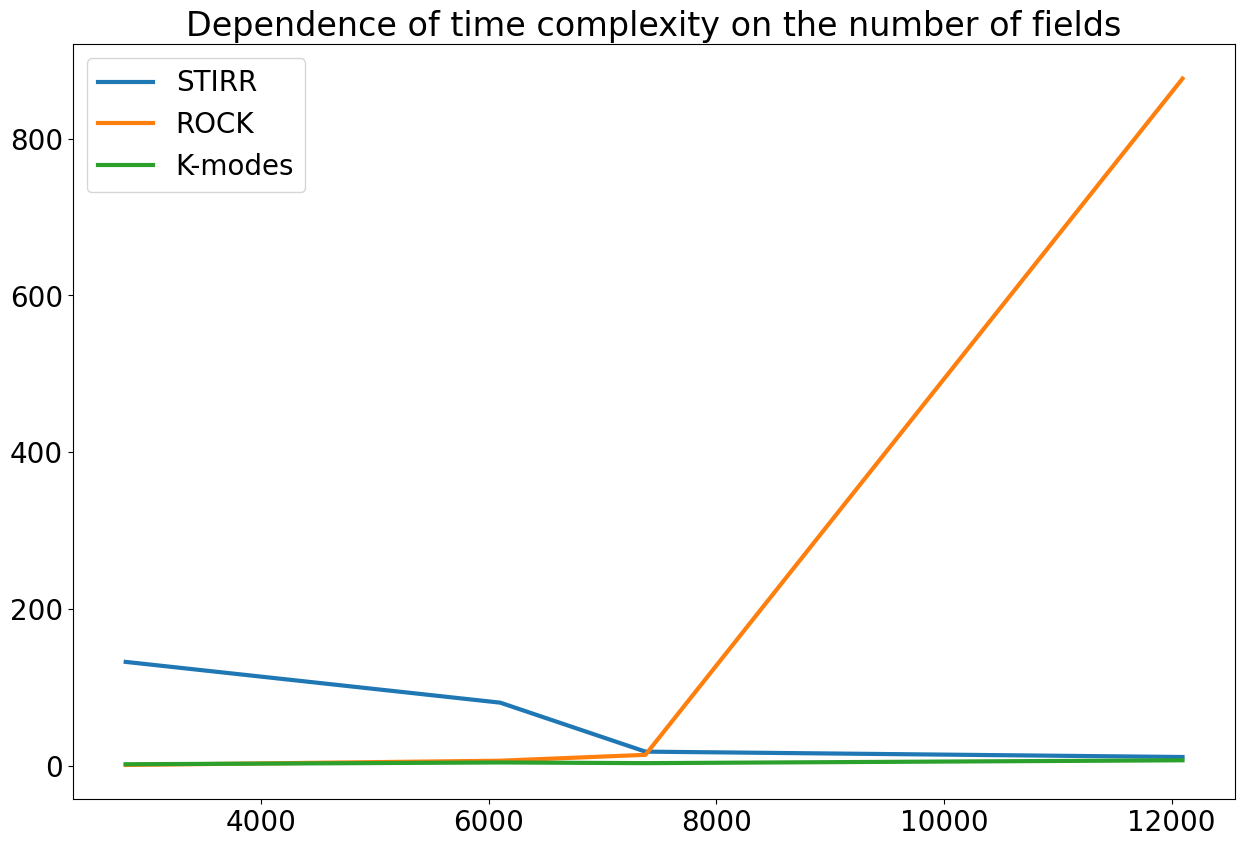

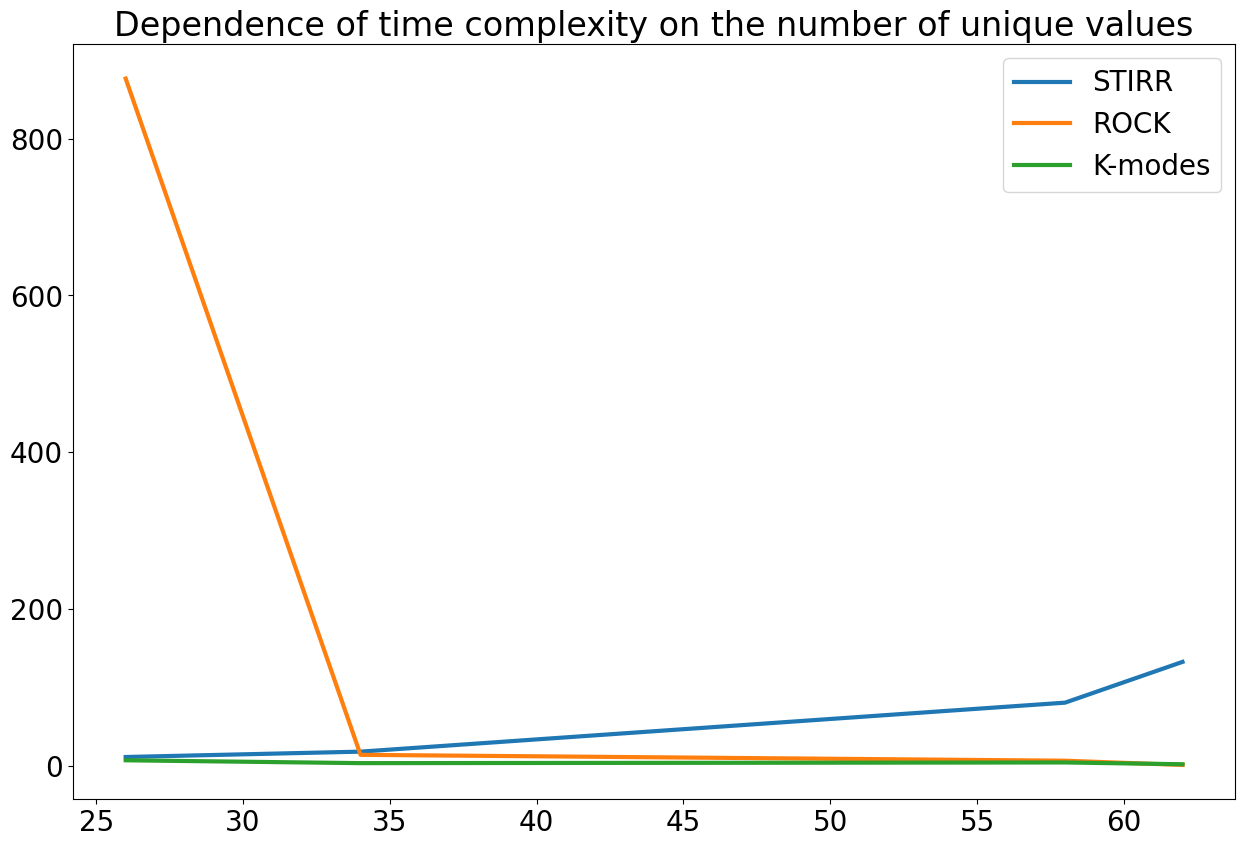

In [21]:
fields = np.multiply(rows, columns)
x, y = zip(*sorted(zip(fields, stirr_times)))
plt.plot(x, y, label='STIRR', linewidth=3.0)
x, y = zip(*sorted(zip(fields, rock_times)))
plt.plot(x, y, label='ROCK', linewidth=3.0)
x, y = zip(*sorted(zip(fields, kmodes_times)))
plt.plot(x, y, label='K-modes', linewidth=3.0)
plt.legend(loc='best')
plt.title("Dependence of time complexity on the number of fields")
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams.update({'font.size': 20, 'axes.labelsize': 20})
plt.rcParams['figure.dpi'] = 100
plt.show()
x, y = zip(*sorted(zip(values, stirr_times)))
plt.plot(x, y, label='STIRR', linewidth=3.0)
x, y = zip(*sorted(zip(values, rock_times)))
plt.plot(x, y, label='ROCK', linewidth=3.0)
x, y = zip(*sorted(zip(values, kmodes_times)))
plt.plot(x, y, label='K-modes', linewidth=3.0)
plt.legend(loc='best')
plt.title("Dependence of time complexity on the number of unique values")
plt.show()

## Cluster distribution and outliers <a class="anchor" id="9"></a>

In [22]:
print("Distribution of clusters and outliers generated by ROCK algorithm:")
for i in range(len(rock_clusters_numbers)):
    print("The number of records contained in individual clusters for the set '", datasets_names[i], "', \nalgorithm parameters: ", rock_parameters[i])
    print(Counter(rock_clusters_numbers[i]))
    print("The number of outliers and non-outliers for the set ", datasets_names[i])
    print(Counter(rock_labels[i]))
    
print("\n\nDistribution of clusters and outliers generated by STIRR algorithm:")
for i in range(len(stirr_sum_weights)):
    print("The number of records contained in individual clusters for the set '", datasets_names[i],"'")
    cluster_1 = sum(j >=0 for j in stirr_sum_weights[i])
    cluster_2 = len(stirr_sum_weights[i])-cluster_1
    print({"1": cluster_1, "2": cluster_2})
    print("The number of outliers and non-outliers for the set ", datasets_names[i])
    nout = sum(j ==1 for j in stirr_labels[i])
    out = len(stirr_labels[i])-nout
    print({"1": nout, "-1": out})
    
print("\n\nDistribution of clusters and outliers generated by K-modes algorithm:")
for i in range(len(kmodes_clusters)):
    print("The number of records contained in individual clusters for the set '", datasets_names[i], "', \nalgorithm parameters: ", kmodes_parameters[i])
    print(Counter(kmodes_clusters[i]))
    print("The number of outliers and non-outliers for the set ", datasets_names[i])
    print(Counter(kmodes_labels[i]))

Distribution of clusters and outliers generated by ROCK algorithm:
The number of records contained in individual clusters for the set ' primary-tumor ', 
algorithm parameters:  (35, 0.55)
Counter({1: 296, 0: 31, 4: 6, 3: 4, 2: 2})
The number of outliers and non-outliers for the set  primary-tumor
Counter({1: 308, -1: 31})
The number of records contained in individual clusters for the set ' lymphography ', 
algorithm parameters:  (16, 0.58)
Counter({4: 56, 1: 43, 2: 26, 0: 8, 3: 4, 5: 4, 7: 3, 6: 2, 8: 2})
The number of outliers and non-outliers for the set  lymphography
Counter({1: 140, -1: 8})
The number of records contained in individual clusters for the set ' house-votes ', 
algorithm parameters:  (43, 0.7)
Counter({3: 191, 1: 145, 2: 18, 0: 16, 12: 7, 11: 5, 4: 4, 5: 4, 21: 4, 24: 3, 27: 3, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 22: 2, 23: 2, 25: 2, 26: 2})
The number of outliers and non-outliers for the set  house-votes
Counter({1: 4

## STIRR- Weight distribution <a class="anchor" id="10"></a>

In [23]:
stirr_weights_encode={}
coded_values = coding_dict[3]
values_weights=stirr_value_weights[3]
for key in coded_values:
    val=coded_values[(key)]
    stirr_weights_encode[(val, key[0])]=values_weights[(key[1], key[0])]
dict(sorted(stirr_weights_encode.items(), key=lambda item: item[1]))

{('med', 'persons'): -0.6988233107,
 ('2', 'maint'): -0.2194720446,
 ('more', 'doors'): -0.1681347455,
 ('vhigh', 'buying'): -0.1633638938,
 ('high', 'class'): -0.156989147,
 ('med', 'class'): -0.0603718183,
 ('2', 'doors'): -0.0289384986,
 ('low', 'buying'): -0.0243522223,
 ('med', 'lug_boot'): -0.0218290968,
 ('med', 'buying'): -0.0203139968,
 ('high', 'lug_boot'): -0.0131304838,
 ('good', 'safety'): -0.0003734395,
 ('unacc', 'safety'): -1.7504e-05,
 ('acc', 'safety'): 2.22832e-05,
 ('vgood', 'safety'): 5.36721e-05,
 ('unaccs', 'safety'): 0.0096731299,
 ('low', 'lug_boot'): 0.0349600086,
 ('5more', 'maint'): 0.0552110533,
 ('4', 'maint'): 0.0552110533,
 ('low', 'class'): 0.0645935603,
 ('3', 'maint'): 0.1090103645,
 ('vhigh', 'class'): 0.1527588223,
 ('4', 'doors'): 0.1971087739,
 ('high', 'buying'): 0.208035132,
 ('small', 'persons'): 0.3014746544,
 ('big', 'persons'): 0.3973887528}

## Method of marking clusters, weights, outliers in selected set <a class="anchor" id="11"></a>

In [24]:
clusters_visualization = variable_encoding(df_3, coding_dict[3])
clusters_visualization['ROCK clusters']=rock_clusters_numbers[3]
clusters_visualization['STIRR weights']=stirr_sum_weights[3]
clusters_visualization['K-modes clusters']=kmodes_clusters[3]
clusters_visualization['ROCK labels']=rock_labels[3]
clusters_visualization['STIRR labels']=stirr_labels[3]
clusters_visualization['K-modes labels']=kmodes_labels[3]
clusters_visualization

,class,buying,maint,doors,persons,lug_boot,safety,ROCK clusters,STIRR weights,K-modes clusters,ROCK labels,STIRR labels,K-modes labels
0,vhigh,vhigh,2,2,small,low,unacc,1,0.077402,5,1,-1,1
1,vhigh,vhigh,2,2,small,med,unacc,1,0.020612,5,1,-1,1
2,vhigh,vhigh,2,2,small,high,unacc,1,0.029311,8,1,-1,1
3,vhigh,vhigh,2,2,med,low,unacc,1,-0.922896,5,1,1,1
4,vhigh,vhigh,2,2,med,med,unacc,1,-0.979686,8,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good,32,-0.793708,0,1,1,1
1724,low,low,5more,more,med,high,vgood,0,-0.784582,0,-1,1,1
1725,low,low,5more,more,big,low,unacc,0,0.359649,1,-1,1,1
1726,low,low,5more,more,big,med,good,32,0.302504,6,1,1,1


## Differences in the classification of outliers <a class="anchor" id="12"></a>

In [25]:
labels=[stirr_labels, rock_labels, kmodes_labels]
algorithms = ["STIRR", "ROCK", "K-modes"]

cm = sns.light_palette("green", as_cmap=True)

th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

td_props = [
  ('font-size', '11px')
  ]

styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]


for k in range(len(stirr_labels)):
    pallete_comparison={"algorithm": algorithms}
    for i in range(len(algorithms)):
        output_tab=[]
        for j in range(len(algorithms)):
            same_out=0
            average_out=np.count_nonzero(labels[i][k]==-1)+np.count_nonzero(labels[j][k]==-1)
            for l in range(len(stirr_labels[k])):
                if labels[i][k][l]==labels[j][k][l] and labels[i][k][l]==-1:
                    same_out+=1
                if labels[i][k][l]==-1 or labels[j][k][l]==-1:
                    average_out+=1
            if average_out==0: 
                output_tab.append(0)
            elif i==j:
                output_tab.append(1)
            else:
                output_tab.append(round(same_out/(average_out/2),2))
        pallete_comparison[algorithms[i]]=output_tab
    df_pallete = pd.DataFrame.from_dict(pallete_comparison)  
    display(df_pallete.style
          .background_gradient(cmap=cm)
          .highlight_max()
          .set_caption(datasets_names[k])
          .format({'total_amt_usd_pct_diff': "{:.2%}"})
          .set_table_styles(styles))

,algorithm,STIRR,ROCK,K-modes
0,STIRR,1.000000,0.060000,0.050000
1,ROCK,0.060000,1.000000,0.610000
2,K-modes,0.050000,0.610000,1.000000


,algorithm,STIRR,ROCK,K-modes
0,STIRR,1.000000,0.000000,0.000000
1,ROCK,0.000000,1.000000,0.710000
2,K-modes,0.000000,0.710000,1.000000


,algorithm,STIRR,ROCK,K-modes
0,STIRR,1.000000,0.070000,0.200000
1,ROCK,0.070000,1.000000,0.270000
2,K-modes,0.200000,0.270000,1.000000


,algorithm,STIRR,ROCK,K-modes
0,STIRR,1.000000,0.050000,0.150000
1,ROCK,0.050000,1.000000,0.110000
2,K-modes,0.150000,0.110000,1.000000


In [26]:
compare_distance_methods={}
compare_distance_methods["comparison"]=["-1 and -1", "1 and 1","different result"]*len(datasets_names)
labels_cat = [stirr_labels, rock_labels, kmodes_labels]
for i in range(len(algorithms)):
    for j in range(i+1, len(algorithms)):
        header=algorithms[i]+"&"+algorithms[j]
        output_tab=[]
        for k in range(len(stirr_labels)):
            same_out=0
            same_nout=0
            different=0
            for l in range(len(stirr_labels[k])):
                if labels_cat[i][k][l]==labels_cat[j][k][l] and labels_cat[i][k][l]==-1:
                    same_out+=1
                elif labels_cat[i][k][l]==labels_cat[j][k][l] and labels_cat[i][k][l]==1:
                    same_nout+=1
                elif labels_cat[i][k][l]!=labels_cat[j][k][l]:
                    different+=1
            output_tab.append(same_out)
            output_tab.append(same_nout)
            output_tab.append(different)
        compare_distance_methods[header]=output_tab
    
names_cat=[]
for n in datasets_names:
    names_cat.append(n)
    names_cat.append(n)
    names_cat.append(n)
    
compare_distance_methods["dataset"] = names_cat
pd.DataFrame.from_dict(compare_distance_methods)

,comparison,STIRR&ROCK,STIRR&K-modes,ROCK&K-modes,dataset
0,-1 and -1,2,2,20,primary-tumor
1,1 and 1,276,252,273,primary-tumor
2,different result,61,85,46,primary-tumor
3,-1 and -1,0,0,6,lymphography
4,1 and 1,125,118,131,lymphography
5,different result,23,30,11,lymphography
6,-1 and -1,2,11,11,house-votes
7,1 and 1,377,326,353,house-votes
8,different result,55,97,70,house-votes
9,-1 and -1,7,26,18,car


## Common outliers generated by the STIRR, ROCK and K-modes algorithms <a class="anchor" id="13"></a>

In [27]:
for index in range(len(datasets)):
    clusters_visualization = variable_encoding(datasets[index], coding_dict[index])
    clusters_visualization['ROCK clusters']=rock_clusters_numbers[index]
    clusters_visualization['STIRR weights']=stirr_sum_weights[index]
    clusters_visualization['K-modes clusters']=kmodes_clusters[index]
    clusters_visualization['ROCK labels']=rock_labels[index]
    clusters_visualization['STIRR labels']=stirr_labels[index]
    clusters_visualization['K-modes labels']=kmodes_labels[index]
    print("Data objects belonging to the ",datasets_names[index]," dataset classified as outliers by all algorithms: STIRR, ROCK and K-modes")
    display(clusters_visualization.loc[(clusters_visualization['STIRR labels'] ==-1) & (clusters_visualization['ROCK labels'] ==-1) & (clusters_visualization['K-modes labels'] ==-1)])

Data objects belonging to the  primary-tumor  dataset classified as outliers by all algorithms: STIRR, ROCK and K-modes


,class,age,sex,histologic-type,degree-of-diffe,bone,bone-marrow,lung,pleura,peritoneum,...,axillar,mediastinum,abdominal,sum_of_weights,ROCK clusters,STIRR weights,K-modes clusters,ROCK labels,STIRR labels,K-modes labels
131,-0.067895,0.136996,0.000277,0.001565,-0.012794,-0.022741,0.000415,0.005342,0.005363,0.000296,...,0.004946,-0.001897,-0.027609,-0.002979,0,-0.002979,3,-1,-1,-1
321,0.019642,-0.023123,0.000277,0.001565,0.000237,-0.022741,0.000415,0.005342,-0.031371,0.000296,...,-0.007503,0.024553,-0.027609,-0.005788,0,-0.005788,1,-1,-1,-1


Data objects belonging to the  lymphography  dataset classified as outliers by all algorithms: STIRR, ROCK and K-modes


,Class,lymphatics,block of affere,bl. of lymph. c,bl. of lymph. s,by pass,extravasates,regeneration of,early uptake in,lym.nodes dimin,...,dislocation of,exclusion of no,no. of nodes in,sum_of_weights,ROCK clusters,STIRR weights,K-modes clusters,ROCK labels,STIRR labels,K-modes labels


Data objects belonging to the  house-votes  dataset classified as outliers by all algorithms: STIRR, ROCK and K-modes


,republican,n,y,n.1,y.1,y.2,y.3,n.2,n.3,n.4,...,y.7,n.5,y.8,sum_of_weights,ROCK clusters,STIRR weights,K-modes clusters,ROCK labels,STIRR labels,K-modes labels
315,-0.141834,0.031125,0.251869,0.147167,0.168047,-0.193775,0.004901,0.023466,-0.414495,0.030702,...,-0.045582,0.177941,0.003649,-0.023109,0,-0.023109,0,-1,-1,-1


Data objects belonging to the  car  dataset classified as outliers by all algorithms: STIRR, ROCK and K-modes


,class,buying,maint,doors,persons,lug_boot,safety,sum_of_weights,ROCK clusters,STIRR weights,K-modes clusters,ROCK labels,STIRR labels,K-modes labels
1621,0.064594,-0.024352,-0.219472,-0.028938,0.301475,-0.021829,-0.000018,0.071459,0,0.071459,2,-1,-1,-1
1622,0.064594,-0.024352,-0.219472,-0.028938,0.301475,-0.01313,-0.000018,0.080157,0,0.080157,2,-1,-1,-1
1646,0.064594,-0.024352,-0.219472,-0.168135,0.397389,-0.01313,0.000054,0.036946,0,0.036946,0,-1,-1,-1
